In [1]:
import fastai2
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

## Data

In [2]:
path = Path('/home/jupyter/data/coco'); path.ls(), len(get_files(path))

((#82783) [/home/jupyter/data/coco/COCO_train2014_000000153985.jpg,/home/jupyter/data/coco/COCO_train2014_000000399983.jpg,/home/jupyter/data/coco/COCO_train2014_000000323774.jpg,/home/jupyter/data/coco/COCO_train2014_000000011426.jpg,/home/jupyter/data/coco/COCO_train2014_000000545128.jpg,/home/jupyter/data/coco/COCO_train2014_000000470618.jpg,/home/jupyter/data/coco/COCO_train2014_000000106941.jpg,/home/jupyter/data/coco/COCO_train2014_000000024980.jpg,/home/jupyter/data/coco/COCO_train2014_000000500585.jpg,/home/jupyter/data/coco/COCO_train2014_000000284088.jpg...],
 82783)

In [3]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=lambda *a, **kw: get_image_files(*a, **kw),
                   splitter=RandomSplitter(0.1, seed=42),
                   get_y=lambda x: x,
                 )

In [4]:
bs, sz = 28, 256
dbch = dblock.databunch(path, bs=bs, item_tfms=[Resize(sz)], batch_tfms=[*aug_transforms(), Normalize(*imagenet_stats)])
dbch.c = 3

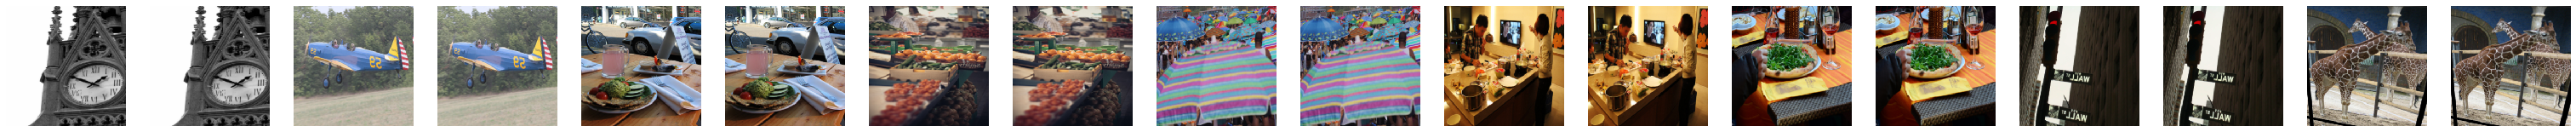

In [5]:
dbch.show_batch(rows=1)

In [6]:
# How can I be sure this is working correctly?
pipe = Pipeline([PILImage.create, ToTensor(), IntToFloatTensor(), Normalize(*imagenet_stats, cuda=False)])
style_timg = TensorImage(pipe('styles/mosaic.jpg').cuda()); style_timg.shape

torch.Size([1, 3, 391, 470])

## Loss func

In [7]:
def gram(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [8]:
base_loss = F.l1_loss
class FSTLoss(nn.Module):
    def __init__(self, m_feat, cnt_ls, stl_ls, cnt_lsw, stl_lsw, stl_loss_mult=1e6):
        super().__init__()
        assert len(cnt_ls) == len(cnt_lsw)
        assert len(stl_ls) == len(stl_lsw)
        self.m_feat,self.cnt_ls,self.stl_ls,self.stl_loss_mult=m_feat,cnt_ls,stl_ls,stl_loss_mult
        self.cnt_lsw = tensor(cnt_lsw).float() / sum(cnt_lsw)
        self.stl_lsw = tensor(stl_lsw).float() / sum(stl_lsw)
        self.cnt_hooks = hook_outputs(cnt_ls, detach=False)
        self.stl_hooks = hook_outputs(stl_ls, detach=False)
        self.metric_names = ['style', 'content']
        # TODO: Temporary
        self.reset_metrics()
        
    def reset_metrics(self): self.metrics = dict(style=[], content=[])
        
    def register_style(self, timg):  _,self.stl_fs = self.get_fs(timg, True)

    def get_fs(self, x, clone=False):
        self.m_feat(x)
        cnt_fs = [(o.clone() if clone else o) for o in self.cnt_hooks.stored]
        stl_fs = [(o.clone() if clone else o) for o in self.stl_hooks.stored]
        return cnt_fs, stl_fs
    
    def forward(self, pred, targ, **kwargs):
        pred_cnt_fs, pred_stl_fs = self.get_fs(pred, True)
        targ_cnt_fs, targ_stl_fs = self.get_fs(targ)
        stl_loss = self.stl_loss_mult*self._stl_loss(pred_stl_fs)
        cnt_loss = self._cnt_loss(pred,targ,pred_cnt_fs,targ_cnt_fs)
        # self.metrics = dict(zip(self.metric_names, [stl_loss, cnt_loss]))
        self.metrics['style'].append(stl_loss); self.metrics['content'].append(cnt_loss)
        return stl_loss + cnt_loss
        
    def _stl_loss(self, pred_fs):
        stl_loss = [base_loss(gram(pred_f),gram(style_f))*w
                    for pred_f,style_f,w in zip(pred_fs,self.stl_fs,self.stl_lsw)]
        return sum(stl_loss)
    
    def _cnt_loss(self, pred, targ, pred_fs, targ_fs):
        cnt_loss =  [base_loss(pred,targ)]
        cnt_loss += [base_loss(pred_f,targ_f)*w for pred_f,targ_f,w
                     in zip(pred_fs,targ_fs,self.cnt_lsw)]
        cnt_loss += [base_loss(gram(pred_f),gram(targ_f))*w for pred_f,targ_f,w
                     in zip(pred_fs,targ_fs,self.cnt_lsw)]
        return sum(cnt_loss)

In [9]:
vgg_m = vgg16_bn(True).features.cuda().eval()
for p in vgg_m.parameters(): p.requires_grad = False
vgg_m.eval(); requires_grad(vgg_m)

False

In [10]:
blocks = [i-1 for i,o in enumerate(vgg_m.children()) if isinstance(o,nn.MaxPool2d)]
bnecks = [vgg_m[i] for i in blocks]

In [11]:
fst_loss = FSTLoss(vgg_m, cnt_ls =bnecks[3:4], stl_ls= bnecks[1:],
                          cnt_lsw=[1]      , stl_lsw=[1, 1, 1, 1], stl_loss_mult=1e5)
fst_loss.register_style(style_timg)

In [12]:
opt_func = lambda ps, lr, **kwargs: Lookahead(RAdam(ps, lr, **kwargs))

## Transformer net

In [13]:
class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        self.model = nn.Sequential(
            ConvBlock(3, 32, kernel_size=9, stride=1),
            ConvBlock(32, 64, kernel_size=3, stride=2),
            ConvBlock(64, 128, kernel_size=3, stride=2),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ConvBlock(128, 64, kernel_size=3, upsample=True),
            ConvBlock(64, 32, kernel_size=3, upsample=True),
            ConvBlock(32, 3, kernel_size=9, stride=1, normalize=False, relu=False),
        )

    def forward(self, x):
        return self.model(x)


class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=True),
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=False),
        )

    def forward(self, x):
        return self.block(x) + x


class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, upsample=False, normalize=True, relu=True):
        super(ConvBlock, self).__init__()
        self.upsample = upsample
        self.block = nn.Sequential(
            nn.ReflectionPad2d(kernel_size // 2), nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        )
        self.norm = nn.InstanceNorm2d(out_channels, affine=True) if normalize else None
        self.relu = relu

    def forward(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2)
        x = self.block(x)
        if self.norm is not None:
            x = self.norm(x)
        if self.relu:
            x = F.relu(x)
        return x

In [14]:
m = TransformerNet()
learn = Learner(dbch, TransformerNet(), loss_func=fst_loss, opt_func=opt_func)

In [15]:
# config = dict(blur=False, self_attention=False, y_range=(-3, 3), norm_type=NormType.Batch)
# learn = unet_learner(dbch, xresnet34, loss_func=fst_loss, opt_func=opt_func, config=config, pretrained=False)

In [16]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # Annoying pytorch broadcast warning: (torch.Size([1, 512, 512])) that is different to the input size (torch.Size([32, 512, 512]))

In [17]:
learn.load('tn-mosaic-128')

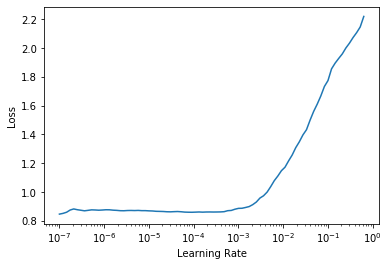

In [18]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(1, 1e-4)

epoch,train_loss,valid_loss,time


In [ ]:
learn.save('tn-mosaic-256')

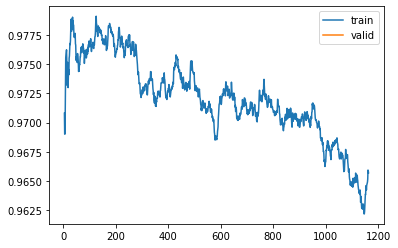

In [31]:
learn.recorder.plot_loss()

In [32]:
fst_loss.reset_metrics()

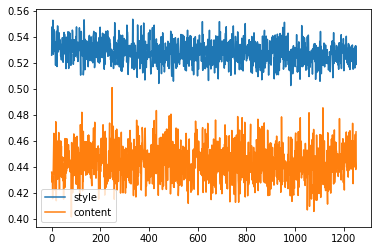

In [32]:
for n, v in fst_loss.metrics.items(): plt.plot(v, label=n)
plt.legend()

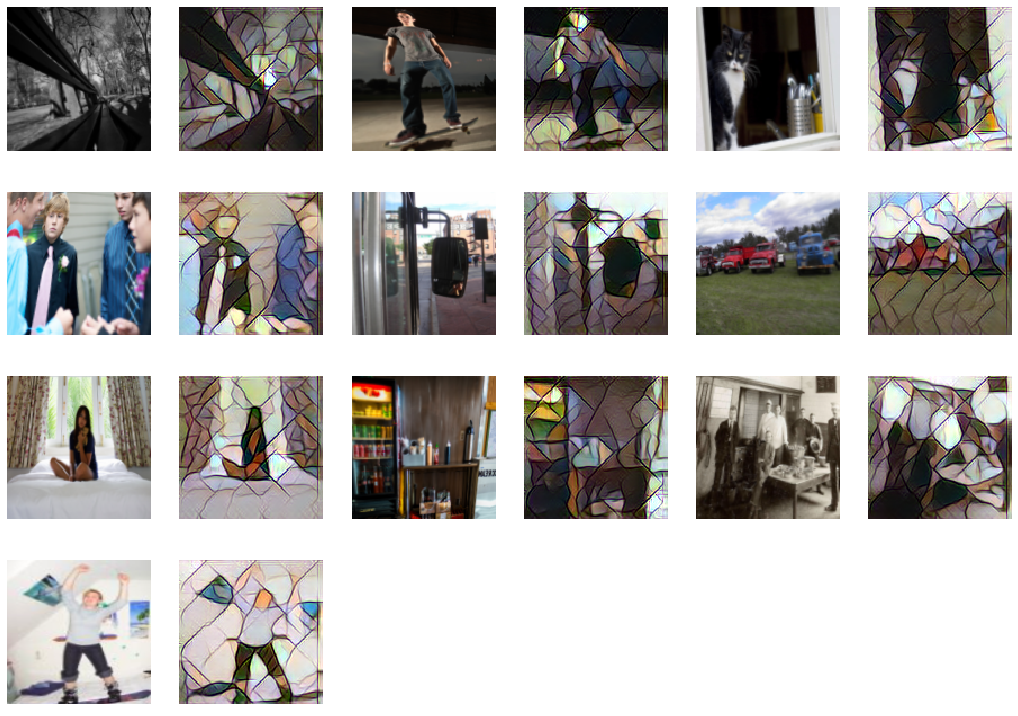

In [33]:
# TODO: Fix bug if max_n != 12
learn.show_results()